#### Ahmed Ayman Ahmed Ali                 1801094
#### Mazen Gasser Mohamed Arfan        1803484
#### Abdullah Osama Sayed                    1802994

# Importing libraries

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

In [2]:
def abs_sobel_thresh(img, orients='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if(orients == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if(orients == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled_sobel = np.uint8((255*abs_sobel)/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [3]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(grad_mag)/255
    
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= thresh[0]) & (grad_mag <= thresh[1])] = 1
    
    return binary_output

In [4]:
def dir_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)
                             )
    binary_output = np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return binary_output

In [5]:
def hls_select(img, thresh=(0,255)):
    #function that converts the image from RGB to HLS and apply thresholdd

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary_output

In [6]:
def warp_image(img):

    img_size = (img.shape[1], img.shape[0])
    
    #defining Src points 
    srcPoints = np.float32([[273,680],
                     [1046,680],
                     [585,455],
                     [700,455]])
    #defining Src points 
    dstPoints = np.float32([[300,720],
                      [980,720],
                      [300,0],
                      [980,0]])
    
    #returns the prespective and inverse prespective matrix for a prespective transform
    M = cv2.getPerspectiveTransform(srcPoints,dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints,srcPoints)
    
    #applies prespective transfore to an image and returns the warped image
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    unwarped_image = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_image, unwarped_image, M, Minv

In [7]:
def hist(img):
    # only the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    return histogram

In [8]:
def find_lane_pixels(warped_image, plot= False):
    
    # make a copy to work on
    binary_warped = warped_image.copy()
    
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    
    # we shouldn't take the range from midpoint to end because it will detect
    # the lane line in the end of the photo not the end of the same lane line
    rightx_base = np.argmax(histogram[midpoint:midpoint + 500]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if plot == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(leftx, ploty, color='yellow')
        plt.plot(rightx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return leftx, lefty, rightx, righty, out_img


In [9]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, plot=False)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [255, 0, 0]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

In [10]:
def fit_continuous(left_fit, right_fit, warped_image, plot = True):
    
    binary_warped = warped_image.copy
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 0, 255]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new, result

In [11]:
def lane_detection(img_file, apply_blur=False):
    #pipeline function to get the output with one function,
    #It is combining some lane detection the steps in one function
    
    image = img_file
    
    # gaussian blur
    if(apply_blur == True):
        kernel_size = 5
        image = cv2.GaussianBlur(image, (kernel_size,kernel_size), 0)
        
    
    # applying gradient and color thresholding then combining
    sobelx_bin = abs_sobel_thresh(image, orients='x', sobel_kernel=3, thresh=(22,100))
    mag_bin = mag_thresh(image, sobel_kernel=3, thresh=(40, 100))
    dir_bin = dir_thresh(image, sobel_kernel=3, thresh=(0.7, 1.3))
    
    S_channel_bin = hls_select(image, thresh=(90,255))
    
    # Combine different binary thresholds
    combined_bin1 = np.zeros_like(sobelx_bin)
    combined_bin1[(sobelx_bin == 1) | (S_channel_bin == 1)] = 1
    
    combined_bin2 = np.zeros_like(sobelx_bin)
    combined_bin2[(sobelx_bin == 1) | (S_channel_bin == 1) | (mag_bin == 1)] = 1
    
    
    warped_image, _,_,_ = warp_image(combined_bin1)
    
    return image, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image

In [12]:
def curvature(left_fit, right_fit, binary_warped, print_data = True):

    #function calculates the radius of curvature of the road and the position from the center of the lane

    ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0])
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    car_position = binary_warped.shape[1]/2
    lane_center_position = (leftx[719] + rightx[719]) / 2
    center = (car_position - lane_center_position) * xm_per_pix
    

    return left_curverad, right_curverad, center

In [13]:
def project_lane_line(warped_image, left_fit, right_fit, orig_img):

    #function to fill the lane and unwarp the image

    new_img = np.copy(orig_img)
    binary_img = np.copy(warped_image)
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    
    filled_warp = np.copy(color_warp)
    _, newwarp,_,_ = warp_image(color_warp)
    
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result, filled_warp

# Display info on the image

In [14]:
def write_on_Image(orig, left_curve,right_curve,center_dist):

    #function to print info on the original image

    test_img = np.copy(orig)
    font = cv2.FONT_HERSHEY_DUPLEX
    rds_of_curve = (left_curve +right_curve)/2
    
    text = 'Radius of curvature: ' + '{:04.2f}'.format(rds_of_curve) + 'm'
    cv2.putText(test_img, text, (40,70), font, 1.5, (228, 242, 68), 2, cv2.LINE_AA)
    
    if center_dist > 0:
        direction = 'right'
    else:
        direction = 'left'
    text = '{:04.3f}'.format(abs(center_dist)) + 'm '+ direction + ' of center'

    cv2.putText(test_img, text, (40,120), font, 1.5, (228, 242, 68), 2, cv2.LINE_AA)
    
    return test_img

# Stacked image function 

In [21]:
def Print_stacked_image(imgArray, resize_param):
    #function that will take an array of images and stack them together to get the stacked image that is used in debugging mode
    
    #resize all images to compine them in one image
    for i in range(0,6):
        imgArray[i] = cv2.resize(imgArray[i], (0, 0), None, resize_param/2, resize_param/1.3)

    h1, w1 = imgArray[0].shape[:2]
    
    imgStack = np.zeros((2*h1, 3*w1, 3), dtype=np.uint8)

    for i in range(0,6):
        if imgArray[i].ndim == 2:
            imgArray[i] = 255 * np.expand_dims(imgArray[i], axis=2)
            

    imgStack[:h1, :w1,:3] = imgArray[0]
    imgStack[:h1, w1:2*w1, :3] = imgArray[1]
    imgStack[:h1, 2*w1:3*w1, :3] = imgArray[2]
    imgStack[h1:2*h1, :w1, :3] = imgArray[3]
    imgStack[h1:2*h1, w1:2*w1, :3] = imgArray[4]
    imgStack[h1:2*h1, 2*w1:3*w1, :3] = imgArray[5]
    
    final = cv2.resize(imgStack,(1280,720))
    return final

# Pipeline function 

In [16]:
def pipeline(img, resize_param):

    image = img
    
    counter = 0
    orig, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image = lane_detection(image, apply_blur=False)

    if counter == 0:
        left_fit, right_fit, out_img = fit_polynomial(warped_image)
    else:
        left_fit, right_fit, out_img  = fit_continuous(left_fit, right_fit, warped_image, plot = False)


    # Get radius of curvature and position
    # return left_curverad, right_curverad, center
    left_curverad, right_curverad, center = curvature(left_fit, right_fit, out_img)

    #fill lane and unwarp
    filled_img, filled_warp = project_lane_line(warped_image, left_fit, right_fit, orig)

    # Print radius of curvature and position on the original photo
    final = write_on_Image(filled_img, left_curverad, right_curverad, center)


    #plt.imshow(out_img)
    img_stack = Print_stacked_image([image, sobelx_bin, warped_image, out_img, filled_warp,final], resize_param)
    
    #return final and stack_image
    return final, img_stack

# Processing and creating the video 

In [17]:
def Prcoess_video(filename,debug ,resize_param, save, show):

    video = cv2.VideoCapture(filename)
    
    #define encoding type
    fourcc = cv2.VideoWriter_fourcc (*'XVID')
    
    #naming the output video
    output_name = "Output.avi"
    
    if(debug == 1):
        output_name = "Output_stacked.avi"

    
    if (video.isOpened() == False): 
        print("Error reading video file")

        
    result = cv2.VideoWriter(output_name, fourcc, 20, (1280,720))
        
    while(video.isOpened()):
        ret, frame = video.read()
        
        if(ret): 
            final, img_stack = pipeline(frame, resize_param)

            if(debug):
                if(save & show):
                    result.write(img_stack)
                    cv2.imshow('img_stack', img_stack)
                elif(save):
                    result.write(img_stack)
                else:
                    cv2.imshow('img_stack', img_stack)
           
            else:
                if(save & show):
                    result.write(final)
                    cv2.imshow('final', final)
                elif(save):
                    result.write(final)
                else:
                    cv2.imshow('final', final)

            if cv2.waitKey(1) & 0XFF == ord('q'):
                break
    
        else:
            break

    video.release()
    result.release()
    cv2.destroyAllWindows()

In [18]:
#debug = input("the number if 0 you will show the final if 1 you will show all detail")
#print("debug " + debug)

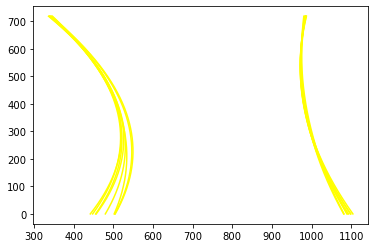

In [22]:
#Prcoess_video('challenge_video.mp4',debug = 1 , resize_param = 0.75 , save = 1, show = 1)

In [ ]:
#take arguments from terminal
def play_video():
    video_name = input("enter video name : ")
    depug = int(input("enter debugging mode : "))
    resize_param = float(input("enter resize_param : "))
    save = int(input("enter save mode (1 => save) : "))
    show = int(input("enter show mode (1 => show): "))
    Prcoess_video(video_name, depug, resize_param, save, show)
        

        
play_video()